In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from typing import Callable, Dict, List, Optional, Tuple, Union

import mne
from mne.io.edf.edf import RawEDF

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


In [23]:
from utils import read_data
from utils import filter_band_raw_to_raw
from utils import filter_band_array_to_array
from utils import rref_REST, rref_remove
from utils import eliminate_blink_corr_electrodes
from utils import create_virtual_channel

In [3]:
# Load data, filter on 0.1-100 [Hz] and rref REST
raw = read_data("../data/h01.edf")
raw_filtered = filter_band_raw_to_raw(raw, [0.1, 100])
raw_REST = rref_REST(raw_filtered)

Extracting EDF parameters from /home/camilojd/Universidad/Primavera_2020/EL7006/dynamicinfo-eeg/data/h01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 231249  =      0.000 ...   924.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 8251 samples (33.004 sec)



In [20]:
def reconstruct_signal(reconst, threshold, ch_names=["Fp1", "Fp2"]):
    reconst_raw = reconst.copy()
    
    # Butter filter (order 2) on mean of Fp1 and Fp2 EEG signals
    ocular_virtual = create_virtual_channel(reconst_raw, ch_names)

    # Decomposition ICA using raw_REST
    raw_ica = reconst.copy()
    ica = mne.preprocessing.ICA(random_state=96)
    ica.fit(raw_ica)

    # Concatenate ocular_virtual with ICA decompositioned data 
    concat_virtual_ica = np.concatenate([np.expand_dims(ocular_virtual, 0), raw_ica.get_data()], axis=0)
    corr_matrix = np.corrcoef(concat_virtual_ica)

    # Find electrodes 'e' with corr(e, ocular_virtual) > threshold
    to_eliminate = eliminate_blink_corr_electrodes(corr_matrix, threshold=threshold)
    print(f'Threshold: {threshold} => Eliminate ICA component(s): {to_eliminate}.')

    # Reconstruction
    # Remove selected components from the signal and reconstruct signal
    ica.apply(reconst_raw, exclude=to_eliminate) 
    
    return reconst_raw, ica

In [26]:
# Params
threshold = 0.2

reconst_raw, ica = reconstruct_signal(raw_filtered, threshold)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting all PCA components: 19 components
Fitting ICA took 3.2s.
Threshold: 0.2 => Eliminate ICA component(s): [ 0  1  5  6 13 16].
Transforming to ICA space (19 components)
Zeroing out 6 ICA components


DEBUG:matplotlib.backends:backend nbAgg version unknown


<IPython.core.display.Javascript object>


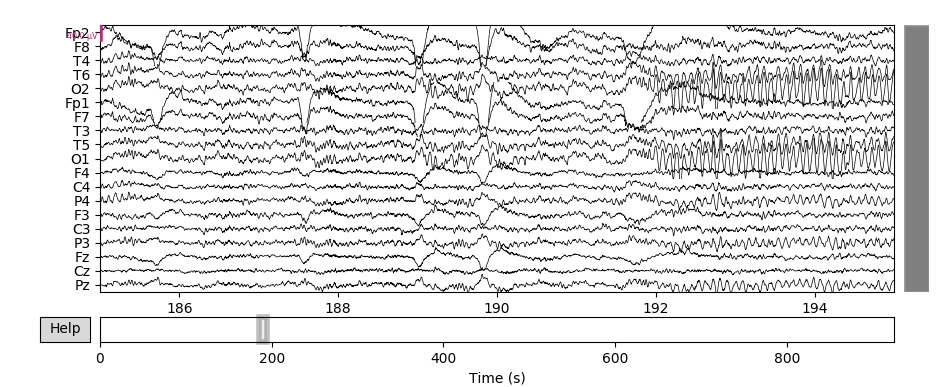

<IPython.core.display.Javascript object>


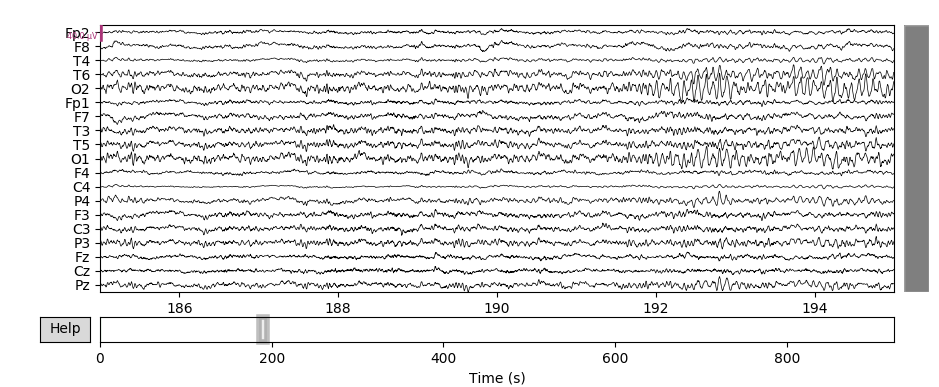

<IPython.core.display.Javascript object>


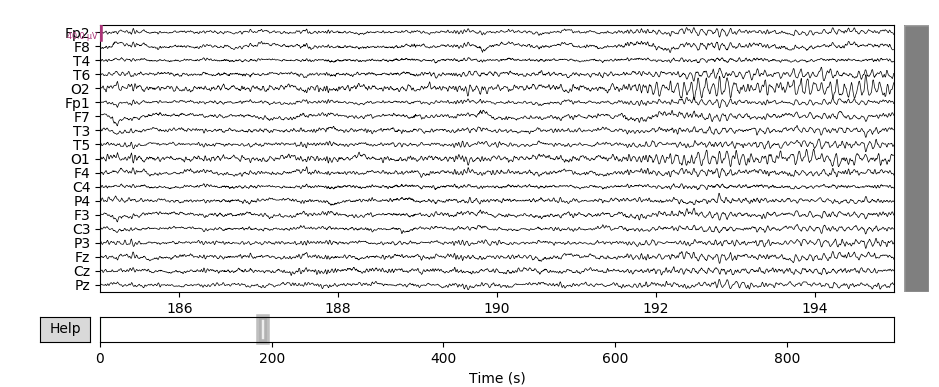

In [28]:
start = 185 #92

%matplotlib notebook
raw_filtered.plot(start=start)
reconst_raw.plot(start=start)
rref_REST(reconst_raw).plot(start=start)
plt.show()

In [6]:
# comparison between raw_REST and raw_ica
#%matplotlib notebook
#raw_REST.plot()
#ica.plot_sources(raw_ica)
#plt.show()

In [7]:
#ica.plot_components(inst=raw_REST) # Project mixing matrix on interpolated sensor topography.

In [8]:
#ica.plot_overlay(raw, exclude=to_eliminate)
#plt.show()